In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/FacebookRecruiting/train.csv
/kaggle/input/FacebookRecruiting/train.gz
/kaggle/input/FacebookRecruiting/bfs_benchmark.csv
/kaggle/input/FacebookRecruiting/random_benchmark.csv
/kaggle/input/FacebookRecruiting/train.zip
/kaggle/input/FacebookRecruiting/test.csv
/kaggle/input/FacebookRecruiting/train.7z


In [2]:
data = pd.read_csv('/kaggle/input/FacebookRecruiting/train.csv')
data

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927
...,...,...
9437514,1862219,1187308
9437515,1862219,563943
9437516,1862219,1044046
9437517,1862219,1022613


In [3]:
data.groupby('source_node')['source_node'].value_counts().sort_values()

source_node  source_node
1862220      1862220           1
563353       563353            1
1338265      1338265           1
1338263      1338263           1
563357       563357            1
                            ... 
1855498      1855498         587
735020       735020          652
141489       141489          759
4850         4850            895
1492489      1492489        1566
Name: source_node, Length: 1587708, dtype: int64

In [4]:
data.isna().any().sum()

0

In [5]:
data[['source_node', 'destination_node']]

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927
...,...,...
9437514,1862219,1187308
9437515,1862219,563943
9437516,1862219,1044046
9437517,1862219,1022613


In [6]:
Graphtype = nx.DiGraph()
G = nx.from_pandas_edgelist(data.head(), source = 'source_node', target = 'destination_node', create_using=Graphtype)

Name: 
Type: DiGraph
Number of nodes: 7
Number of edges: 5
Average in degree:   0.7143
Average out degree:   0.7143


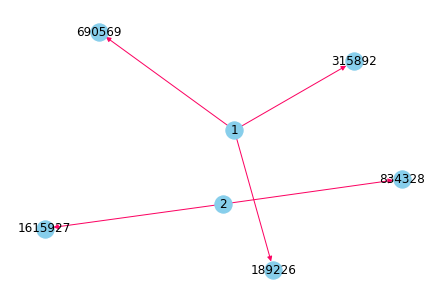

In [7]:
pos=nx.spring_layout(G)
nx.draw(G,pos,node_color='#87ceeb',edge_color='#fc0362', with_labels=True)
print(nx.info(G))

In [8]:
data['source_node'].nunique()

1587708

In [9]:
data['source_node'].nunique() / data.shape[0]

0.16823362156939764

In [10]:
H = G.to_undirected()
for i in nx.ego_graph(H, 1, radius=2, undirected=False).edges:
    print(nx.jaccard_coefficient(H, i))
    #list.append(tuple(i))

<generator object _apply_prediction.<locals>.<genexpr> at 0x7f003afaae60>
<generator object _apply_prediction.<locals>.<genexpr> at 0x7f003afaae60>
<generator object _apply_prediction.<locals>.<genexpr> at 0x7f003afaae60>


In [11]:
for u, v, p in nx.jaccard_coefficient(H, nx.ego_graph(H, 1, radius=2, undirected=False).edges):
    print(p)

0.0
0.0
0.0
